[Reference](https://pub.towardsai.net/time-series-forecasting-building-and-deploying-models-f647c2ec7567)

In [31]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Medium

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Medium


In [32]:
import numpy as np
import pandas as pd
cooleff = [] 
ce = open('./hyddata/features/CE.txt','r') # Read in a new file
for line in ce:
    cooleff.append(line.split()) # Read in each line of opened file, while separating each line.
cooleff = np.reshape(cooleff,(2205,60)) # Reshape the array
cooleffDF = pd.DataFrame(cooleff)       # Convert array to dataframe

In [33]:
cooleffDF

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
0,47.202,47.273,47.25,47.332,47.213,47.372,47.273,47.438,46.691,46.599,46.623,46.653,46.136,46.127,45.948,45.935,45.726,45.139,44.978,44.937,44.269,44.079,43.741,43.375,42.847,42.322,42.322,41.797,41.406,40.924,40.427,39.857,39.517,38.999,38.493,37.954,37.552,37.084,36.615,36.098,35.58,35.141,34.184,34.177,33.739,33.226,32.913,32.4,31.833,31.862,31.554,30.953,30.639,30.561,30.368,30.224,29.79,29.261,29.287,28.866
1,29.208,28.822,28.805,28.922,28.591,28.643,28.216,27.812,27.514,27.481,27.631,27.464,27.258,27.424,26.955,27.023,26.834,27.073,27.26,27.236,26.72,26.824,26.757,26.311,26.431,25.515,25.724,25.724,25.59,25.257,25.296,25.475,24.716,25.037,24.784,24.848,24.925,24.47,24.74,24.436,24.245,24.433,24.546,24.13,24.42,24.341,24.341,24.503,24.458,24.04,23.995,24.328,24.283,23.877,23.816,23.933,23.354,23.483,23.32,23.588
2,23.554,23.521,23.527,23.008,23.042,23.052,22.658,22.952,22.908,22.359,22.287,22.213,22.562,22.525,22.725,22.63,22.745,22.643,22.997,22.997,22.903,22.761,22.701,22.818,22.785,22.667,22.729,22.82,22.087,22.25,22.121,21.979,21.772,21.945,21.863,21.627,21.51,21.445,21.54,21.436,21.853,21.894,21.797,21.377,21.645,21.453,21.788,21.22,21.775,21.575,21.711,21.564,21.564,21.526,21.753,21.749,21.802,21.582,21.283,21.519
3,21.54,21.419,21.565,20.857,21.052,21.039,20.926,20.912,20.989,20.882,20.596,20.465,20.604,20.672,20.453,20.479,20.621,20.717,20.342,20.777,20.676,20.747,20.689,20.79,21.061,20.307,20.181,20.307,20.144,19.783,19.804,19.749,19.875,20.155,19.913,19.83,19.709,19.771,19.675,20.25,20.109,19.884,20.084,19.673,20.121,20.367,20.527,20.054,20.415,20.325,20.687,20.703,20.295,20.482,20.6,20.547,20.708,20.708,20.574,20.403
4,20.46,20.298,20.35,19.867,19.997,19.972,19.924,19.813,19.691,19.634,19.133,19.14,19.444,19.457,19.815,19.329,19.67,19.965,19.868,19.628,20.041,19.913,20.164,20.037,20.402,20.152,20.148,20.085,19.614,19.686,19.949,19.925,19.818,19.5,19.52,19.468,19.831,19.339,19.419,19.327,19.331,19.681,19.784,19.713,19.772,19.752,19.643,19.58,19.71,19.926,19.887,19.919,19.696,19.634,19.747,20.005,19.919,19.736,19.977,20.016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,46.798,46.688,46.699,46.844,46.819,46.725,46.713,46.832,46.727,46.362,46.384,46.362,46.657,46.657,46.611,46.891,46.999,47.016,46.94,46.881,46.928,46.785,47.092,46.94,46.879,46.914,46.477,46.362,46.453,46.467,46.976,46.268,46.963,46.421,46.987,46.891,46.527,46.656,46.739,46.62,46.657,46.623,46.563,46.635,46.632,46.586,46.526,46.339,46.4,46.432,46.375,46.334,46.395,46.264,46.325,46.255,46.375,46.421,46.242,46.382
2201,46.477,46.525,46.013,46.349,46.345,46.286,46.156,46.406,46.188,45.762,45.859,46.101,46.11,46.037,46.147,46.479,46.348,46.49,46.502,46.453,46.894,47.486,47.264,47.147,47.169,47.16,47.193,47.157,47.018,47.137,47.242,47.124,47.086,47.087,47.087,46.889,46.911,46.971,47.067,47.041,46.898,46.868,46.997,46.864,47.055,46.649,46.615,46.623,46.781,46.653,46.529,46.77,46.649,46.565,46.532,46.521,46.615,46.603,46.71,46.729
2202,46.757,46.863,46.756,46.863,46.816,46.813,46.863,46.863,46.849,46.71,46.71,46.649,46.612,46.914,46.841,46.915,47.147,47.123,46.94,46.825,47.206,46.918,46.845,46.74,46.915,46.716,46.915,46.832,46.776,46.708,46.693,46.812,46.938,46.566,46.588,46.55,46.137,46.067,46.085,46.172,45.992,46.149,46.137,45.948,45.762,45.8,45.766,45.812,45.873,45.73,45.886,45.715,45.683,45.836,45.943,45.774,46.051,45.8,46.171,46.502
2203,46.584,46.469,46.538,46.538,46.477,46.432,46.491,46.514,46.539,46.432,46.334,45.846,45.897,46.172,46.172,46.254,46.387,46.385,46.458,46.293,46.371,46.508,46.397,46.397,46.348,46.387,46.964,46.752,47.001,46.729,47.001,46.871,46.809,46.706,46.742,46.63

In [34]:
import numpy as np
import pandas as pd
import glob
locn = "./hyddata/features/*.txt" # find all the text files in the path 
files = glob.glob(locn) # Compile list of aforementioned text files
features = {} # use a dictionary to save all the variables

for name in files:
    try:
        with open(name) as f:
            # read in the data 
            temp_df = pd.read_csv(name,delim_whitespace=True,header=None)
            # make the row names cycle as a variable
            temp_df.index.name = 'cycle'
            temp_df.reset_index(inplace=True)
            # transpose the data 
            temp_df_transposed= temp_df.T
            # make the seconds a variable, call it "time”
            temp_df_transposed.index.name = 'time'
            temp_df_transposed.reset_index(inplace=True)
            # add a prefix cycle in the column names to help with pivoting data (from wide to long)
            string = ' cycle'.join(str(e) for e in list(temp_df_transposed.columns))
            temp_df_transposed.columns = string.split(" ")
            # From wide to long to help with joining all the variables 
            temp_df_long = pd.wide_to_long(temp_df_transposed.iloc[1:,:],stubnames='cycle', i=['time'], j='c')
            temp_df_long.reset_index(inplace=True)
            # save each data variable in the long format into separate data frames in the dictionary called "features"
            # but exclude path and txt in the names
            features[name[9:-4]] = temp_df_long
                        
           
    
    # prevent a possible error
    except IOError as exc:
        if exc.errno != errno.EISDIR:
            raise

In [36]:
temp_df.head()

time,cycle,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
0,0,0.604,0.605,0.611,0.603,0.608,0.608,0.608,0.617,0.619,0.619,0.581,0.569,0.558,0.548,0.544,0.534,0.534,0.532,0.534,0.555,0.553,0.563,0.581,0.595,0.584,0.582,0.585,0.577,0.569,0.577,0.597,0.596,0.603,0.605,0.603,0.600,0.604,0.624,0.616,0.593,0.607,0.592,0.585,0.572,0.577,0.576,0.568,0.563,0.559,0.557,0.554,0.552,0.545,0.553,0.553,0.539,0.544,0.545,0.535,0.543
1,1,0.590,0.610,0.626,0.620,0.623,0.619,0.617,0.618,0.619,0.615,0.578,0.556,0.551,0.539,0.545,0.535,0.528,0.524,0.530,0.537,0.551,0.551,0.564,0.567,0.566,0.562,0.555,0.556,0.557,0.566,0.568,0.574,0.580,0.580,0.581,0.582,0.578,0.573,0.570,0.570,0.568,0.567,0.555,0.557,0.553,0.556,0.547,0.552,0.588,0.567,0.555,0.547,0.548,0.544,0.536,0.542,0.540,0.533,0.531,0.534
2,2,0.578,0.603,0.638,0.651,0.652,0.662,0.662,0.656,0.652,0.638,0.604,0.601,0.586,0.563,0.543,0.534,0.534,0.529,0.531,0.561,0.554,0.559,0.568,0.585,0.584,0.571,0.558,0.555,0.561,0.594,0.615,0.605,0.603,0.587,0.590,0.599,0.588,0.590,0.583,0.564,0.560,0.559,0.561,0.550,0.560,0.554,0.561,0.566,0.558,0.547,0.543,0.544,0.543,0.554,0.544,0.544,0.545,0.544,0.530,0.534
3,3,0.565,0.591,0.608,0.614,0.623,0.645,0.642,0.645,0.642,0.643,0.598,0.570,0.558,0.544,0.538,0.532,0.527,0.529,0.530,0.545,0.536,0.548,0.548,0.552,0.555,0.549,0.547,0.556,0.562,0.570,0.577,0.584,0.629,0.614,0.602,0.602,0.601,0.595,0.587,0.568,0.557,0.550,0.558,0.551,0.555,0.550,0.551,0.551,0.551,0.548,0.549,0.538,0.553,0.543,0.553,0.555,0.544,0.543,0.543,0.542
4,4,0.570,0.600,0.623,0.636,0.644,0.642,0.651,0.654,0.660,0.644,0.595,0.578,0.561,0.546,0.547,0.538,0.553,0.534,0.524,0.546,0.545,0.560,0.585,0.585,0.576,0.567,0.578,0.571,0.576,0.583,0.580,0.589,0.598,0.602,0.599,0.605,0.596,0.587,0.592,0.581,0.567,0.589,0.583,0.585,0.577,0.570,0.562,0.555,0.561,0.564,0.546,0.546,0.544,0.552,0.539,0.540,0.549,0.542,0.533,0.537


In [37]:
label = pd.read_csv ("./hyddata/profile.txt", delim_whitespace=True, header=None)
label.columns = ['cooler_condition', 'valve_condition', 'pump_leak', 'hydraulic_accumulator', 'stable_flag']

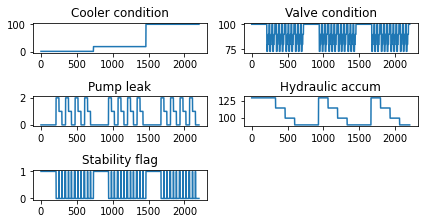

In [46]:
import matplotlib.pyplot as plt

plt.figure()
plt.subplot(4,2,1)
label.cooler_condition.plot() 
plt.title('Cooler condition')

plt.subplot(4,2,2)
label.valve_condition.plot(ax=plt.gca())
plt.title('Valve condition')

plt.subplot(4,2,3)
label.pump_leak.plot(ax=plt.gca())
plt.title('Pump leak')

plt.subplot(4,2,4)
label.hydraulic_accumulator.plot(ax=plt.gca())
plt.title('Hydraulic accum')

plt.subplot(4,2,5)
label.stable_flag.plot(ax=plt.gca())
plt.title('Stability flag')

plt.tight_layout()

In [44]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 

In [45]:
univar = series_to_supervised(label[['hydraulic_accumulator']],n_in=2,n_out=1)
# Creating a dataframe above for use in a supervised learning problem. 2 columns will have 2 preceding values in the sequence while the last column features value at that time i.e. the label
univar = univar.values
train,test = univar[:1201,:], univar[1202:,:]
# Creating training and testing sets, by simply splitting the data.
# Final step below splits training and testing sets into features and labels. Remember that only the last column features labels i.e. the y.
xtrain,ytrain = train[:,0:2],train[:,-1]
xtest,ytest = test[:,0:2],test[:,-1]

In [51]:
xtrain = xtrain.reshape((xtrain.shape[0], 1, xtrain.shape[1]))
xtest = xtest.reshape((xtest.shape[0], 1, xtest.shape[1]))

In [52]:
%pip install keras
%pip install tensorflow
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, LSTM

model = Sequential()
model.add(LSTM(60, input_shape=(xtrain.shape[1], xtrain.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(xtrain, ytrain, epochs=50, batch_size=20, validation_data=(xtest, ytest), verbose=0, shuffle=False)

In [53]:
univar = series_to_supervised(label[['stable_flag']],n_in=2,n_out=1)
univar = univar.values

train,test = univar[:1201,:], univar[1202:,:]

xtrain,ytrain = train[:,0:2],train[:,-1]
xtest,ytest = test[:,0:2],test[:,-1]

xtrain = xtrain.reshape((xtrain.shape[0], 1, xtrain.shape[1]))
xtest = xtest.reshape((xtest.shape[0], 1, xtest.shape[1]))

model = Sequential()
model.add(LSTM(60, input_shape=(xtrain.shape[1], xtrain.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(xtrain, ytrain, epochs=50, batch_size=20, validation_data=(xtest, ytest), verbose=0, shuffle=False)

In [55]:
from matplotlib import pyplot

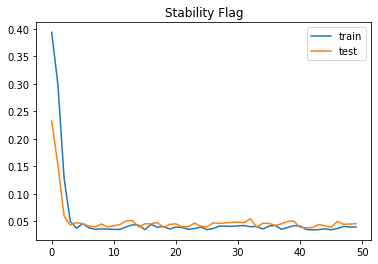

In [56]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.title('Stability Flag')
pyplot.show()

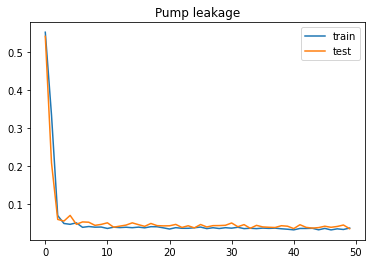

In [57]:
univar = series_to_supervised(label[['pump_leak']],n_in=2,n_out=1)
univar = univar.values

train,test = univar[:1201,:], univar[1202:,:]

xtrain,ytrain = train[:,0:2],train[:,-1]
xtest,ytest = test[:,0:2],test[:,-1]

xtrain = xtrain.reshape((xtrain.shape[0], 1, xtrain.shape[1]))
xtest = xtest.reshape((xtest.shape[0], 1, xtest.shape[1]))

model = Sequential()
model.add(LSTM(60, input_shape=(xtrain.shape[1], xtrain.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(xtrain, ytrain, epochs=50, batch_size=20, validation_data=(xtest, ytest), verbose=0, shuffle=False)

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.title('Pump leakage')
pyplot.show()

In [58]:
yhat = model.predict(xtest)
from sklearn.metrics import mean_absolute_error
mean_absolute_error(yhat,ytest)

0.03447082924696577

# Feature Engineering


In [64]:
# for key in list(features.keys()):
#     features[key].columns=['seconds','cycle',key]

# dfs= [features['./hyddata/features/CE'],
#       features['./hyddata/features/CP'],
#       features['./hyddata/features/EPS1'],
#       features['./hyddata/features/FS1'],
#       features['./hyddata/features/FS2'],
#       features['./hyddata/features/PS1'],
#       features['./hyddata/features/PS2'],
#       features['./hyddata/features/PS3'],
#       features['./hyddata/features/PS4'],
#       features['./hyddata/features/PS5'],
#       features['./hyddata/features/PS6'],
#       features['./hyddata/features/SE'],
#       features['./hyddata/features/TS1'],
#       features['./hyddata/features/TS2'],
#       features['./hyddata/features/TS3'],
#       features['./hyddata/features/TS4'],
#       features['./hyddata/features/VS1']]

# from functools import reduce
# features_join = reduce(lambda left,right: pd.merge(left,right,on=['seconds','cycle']), dfs)
# features_join.head()

In [65]:
# %pip install tsfresh
# from tsfresh import select_features
# from tsfresh import extract_features
# from tsfresh.utilities.dataframe_functions import impute
# from tsfresh import extract_relevant_features

# # Automatic feautre extraction using the tsfresh package
# extracted_features = extract_features(features_join, column_id="cycle", column_sort="seconds")

In [66]:
# impute(extracted_features)